## Faster Training Using PCA

Given is the dataset `sensor.csv` which contains 100 columns with sensor data of a machine at time `t` (`s0`, `s1`, ..., `s99`). In addition, the binary variable `failure` is given, which provides information about whether a machine failure has occurred in the 10 minutes after `t`.

In [1]:
import pandas as pd

# Read dataset
sensor = pd.read_csv('../resources/sensor.csv')
sensor.head()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s91,s92,s93,s94,s95,s96,s97,s98,s99,failure
0,-0.471203,-1.013745,-0.027428,1.889180,2.197274,0.678035,0.171012,-1.375867,0.405758,2.909446,...,-0.037079,0.335492,0.085324,-0.074864,0.821507,-0.925415,-1.317402,3.432796,2.159853,0
1,0.941079,-0.172493,1.413977,5.036312,1.091818,-1.150420,2.084293,-0.520226,1.674825,0.566167,...,-2.545771,0.128337,0.442732,2.006514,0.268426,0.235319,2.744172,-1.412744,-5.994016,0
2,-1.195732,-1.929801,-0.182574,4.307167,0.303782,0.840358,0.936226,-3.449026,0.701125,0.917662,...,-2.930188,-0.572917,1.269583,-0.283146,-1.593536,-0.661609,-0.396231,9.573559,-15.802268,0
3,-0.233510,0.785644,-1.564440,3.446944,-2.184945,-0.627282,-0.350289,4.721569,0.573101,0.136052,...,1.580185,-1.753102,-0.270561,0.951940,1.022105,-0.099876,0.848960,5.064528,1.147706,0
4,-0.872263,-0.418136,0.593664,-0.122257,0.353434,0.741675,0.444588,3.136166,1.028023,-0.076499,...,1.801601,0.092531,0.303533,-1.610319,1.597862,0.207476,-0.536521,-0.159098,-5.260153,1


You have already set up a model to predict machine failures based on the sensor data in columns `s1`, `s2`, ..., `s99`. Fortunately, the ROC curve already meets the quality criteria of your stakeholders.

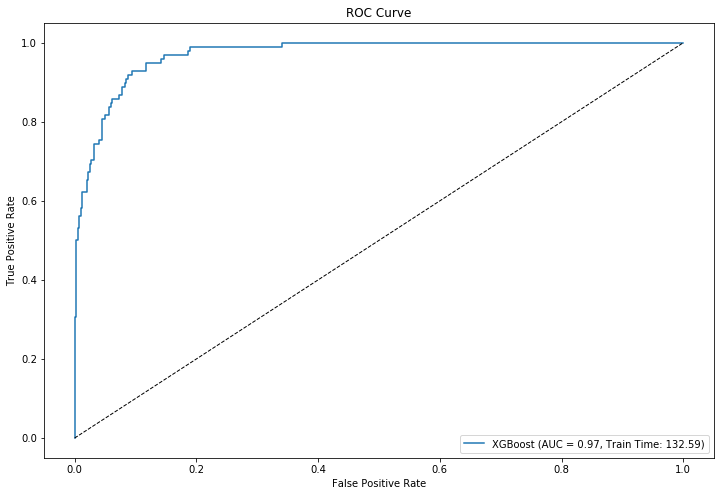

In [2]:
# Import packages
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Create train test split
X, y = sensor.drop('failure', axis=1), sensor['failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Initialize xgboost classifier
xgb = XGBClassifier(
    random_state=0, 
    use_label_encoder = False, 
    eval_metric = "logloss"
)

# Initialize random search trainer
cv = RandomizedSearchCV(
    estimator = xgb,
    param_distributions = {
        'max_depth': [4, 5, 6, 7, 8, 9, 10],
        'n_estimators': [100, 200, 300, 400, 500]
    }
)

# Train model
start = time.time()
cv.fit(X_train, y_train)
end = time.time()
train_time = end-start

# Evaluate model
scores = cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc = roc_auc_score(y_test, scores)

# Plot ROC curve
plt.figure(figsize=(12, 8))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f}, Train Time: {train_time:.2f})')
plt.plot([0, 1], [0, 1], color='black', ls='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Unfortunately, the model training takes too long to put into production. You decide to add a principal component analysis (PCA) to the training pipeline to reduce the amount of data to be processed in the training. After implementation you compare the prediction accuracy and training time of both solutions.

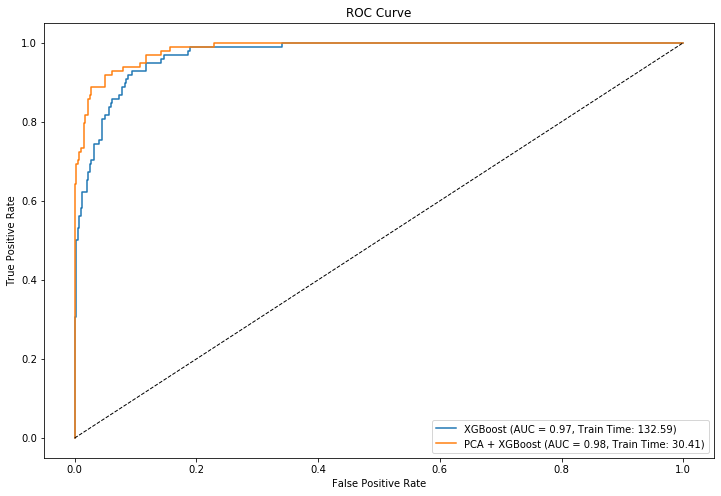

In [3]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Initialize pca
pca = PCA()

# Create pipeline
pipeline = Pipeline([
    ('pca', pca),
    ('xgb', xgb)
])

# Initialize random search trainer
cv = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = {
        'pca__n_components': [5, 10, 15, 20],
        'xgb__max_depth': [4, 5, 6, 7, 8, 9, 10],
        'xgb__n_estimators': [100, 200, 300, 400, 500]
    }
)

# Train model
start = time.time()
cv.fit(X_train, y_train)
end = time.time()
train_time2 = end-start

# Evaluate model
scores2 = cv.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, scores2)
auc2 = roc_auc_score(y_test, scores2)

# Plot ROC curve
plt.figure(figsize=(12, 8))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f}, Train Time: {train_time:.2f})')
plt.plot(fpr2, tpr2, label=f'PCA + XGBoost (AUC = {auc2:.2f}, Train Time: {train_time2:.2f})')
plt.plot([0, 1], [0, 1], color='black', ls='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()